In [1]:
from data import HomDensityDataset
import matplotlib.pyplot as plt

data = HomDensityDataset(
    root="/export/canton/data/yma93/anydim_transferability/GNN_size_generalizability",
    N=500,
    n=50,
    graph_model="full_SBM_Gaussian",
    task="triangle",
)

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


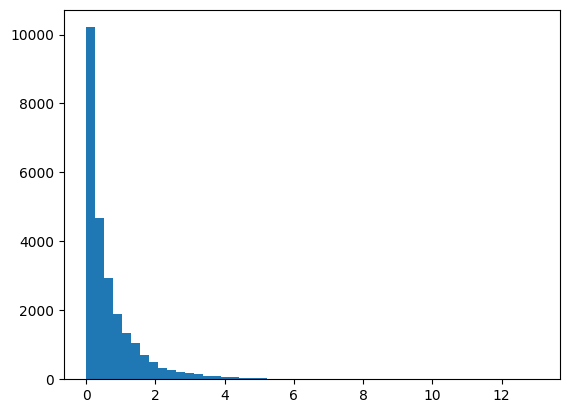

In [2]:
plt.hist(data.y, bins=50)
plt.show()

In [6]:
(data.y**2).mean().sqrt()

tensor(1.1796)

In [ ]:
from ign_layers import layer_2_to_2_anydim, layer_2_to_1_anydim
import torch

gnn = layer_2_to_2_anydim(input_depth=1, output_depth=3)
gnn.all_bias = torch.nn.Parameter(torch.ones(1, 3, 1, 1))
A = torch.randn(5, 3, 30, 30) * 50
A2 = torch.kron(A, torch.ones(1, 1, 5, 5))
A = gnn(gnn(A))
A2 = gnn(gnn(A2))
print(
    torch.max(
        torch.abs(
            torch.kron(A, torch.ones(1, 1, 5, 5)) - A2,
        )
    )
)

In [ ]:
A = torch.randn(5, 3, 30, 30) * 50
A2 = torch.kron(A, torch.ones(1, 1, 5, 5))
gnn = layer_2_to_1_anydim(input_depth=3, output_depth=3)
X = gnn(A)
X2 = gnn(A2)
print(
    torch.max(
        torch.abs(
            torch.kron(X, torch.ones(1, 1, 5)) - X2,
        )
    )
)

In [ ]:
# check whether model is compatible
from model import GNN_layer
import torch

reduced = True
gnn1 = GNN_layer(
    A_in_channels=1, A_out_channels=3, x_in_channels=3, x_out_channels=3, reduced=reduced
)
# gnn1.A_bias = torch.nn.Parameter(torch.ones(1,1,1,3))
# gnn1.X1_bias = torch.nn.Parameter(torch.ones(1, 1, 3))
# gnn1.X1_bias = torch.nn.Parameter(torch.ones(1, 1, 3))
gnn2 = GNN_layer(
    A_in_channels=3, A_out_channels=3, x_in_channels=3, x_out_channels=3, reduced=reduced
)
# gnn2.A_bias = torch.nn.Parameter(torch.ones(1, 1, 1, 3))
# gnn2.X1_bias = torch.nn.Parameter(torch.ones(1, 1, 3))
# gnn2.X1_bias = torch.nn.Parameter(torch.ones(1, 1, 3))

A = torch.randn(5, 1, 30, 30) * 5
X = torch.randn(5, 30, 3) * 50
A2 = torch.kron(A, torch.ones(1, 1, 10, 10))
X2 = torch.kron(X, torch.ones(1, 10, 1))

A, X = gnn1(A, X)
A, X = gnn2(A, X)
A = A.contiguous()
X = X.contiguous()

A2, X2 = gnn1(A2, X2)
A2, X2 = gnn2(A2, X2)
A2 = A2.contiguous()
X2 = X2.contiguous()

In [ ]:
print(
    torch.max(
        torch.abs(
            torch.kron(A, torch.ones(1, 1, 10, 10)) - A2,
        )
    )
)

In [ ]:
print(torch.max(torch.abs((torch.kron(X, torch.ones(1, 10, 1)) - X2) / X2)))

In [ ]:
torch.allclose(torch.kron(A, torch.ones(1, 1, 10, 10)), A2, atol=1e-2)

In [ ]:
torch.allclose(torch.kron(X, torch.ones(1, 10, 1)), X2, rtol=1e-2)

In [ ]:
X[0, :, 0]

In [ ]:
X2[0, :, 0]

dict_keys(['ign', 'simple', 'reduced', 'unreduced'])
[0.00502564 0.00366329 0.00336777 0.00342227 0.00317422]
[0.00536976 0.00372024 0.00338808 0.00343722 0.0032163 ]
[0.00571388 0.00377718 0.00340839 0.00345216 0.00325838]
[0.00728471 0.00486538 0.00456896 0.00434008 0.00423353]


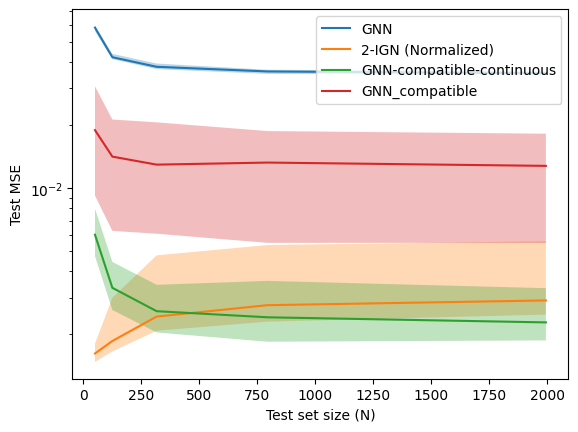

In [18]:
import os, json
import numpy as np
import matplotlib.pyplot as plt

num_trials = 10
log_test_n_range = np.arange(1.7, 3.4, 0.4)
test_n_range = np.array([int(10**i) for i in log_test_n_range])

fname = f"results_full_SBM_Gaussian_triangle.json"
with open(os.path.join("log/size_generalization", fname), "r") as f:
    results = json.load(f)
print(results.keys())
model_name = {
    "simple": "GNN",
    "ign": "2-IGN (Normalized)",
    "reduced": "GNN-compatible-continuous",
    "unreduced": "GNN_compatible",
}
for model in ["simple", "ign", "reduced", "unreduced"]:
    current_directory = os.getcwd()

    mse_list = [results[model][str(seed)] for seed in range(num_trials)]
    x = np.array(test_n_range)
    plt.plot(x, np.median(mse_list, axis=0), label=model_name[model])
    plt.fill_between(
        x,
        # np.mean(mse_list, axis=0) - np.std(mse_list, axis=0),
        # np.mean(mse_list, axis=0) + np.std(mse_list, axis=0),
        # np.min(mse_list, axis=0),
        # np.max(mse_list, axis=0),
        # min_mse,
        # max_mse,
        np.percentile(mse_list, 20, axis=0),
        np.percentile(mse_list, 80, axis=0),
        alpha=0.3,
    )
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("Test set size (N)")
plt.ylabel("Test MSE")
plt.legend(loc="upper right")
print(np.min(mse_list, axis=0))
print(np.percentile(mse_list, 5, axis=0))
print(np.percentile(mse_list, 10, axis=0))
print(np.percentile(mse_list, 15, axis=0))

# output

dict_keys(['train_outputs', 'train_truths', 'test_outputs', 'test_truths']) dict_keys(['outputs', 'truths'])
dict_keys(['train_outputs', 'train_truths', 'test_outputs', 'test_truths']) dict_keys(['outputs', 'truths'])
dict_keys(['train_outputs', 'train_truths', 'test_outputs', 'test_truths']) dict_keys(['outputs', 'truths'])
dict_keys(['train_outputs', 'train_truths', 'test_outputs', 'test_truths']) dict_keys(['outputs', 'truths'])


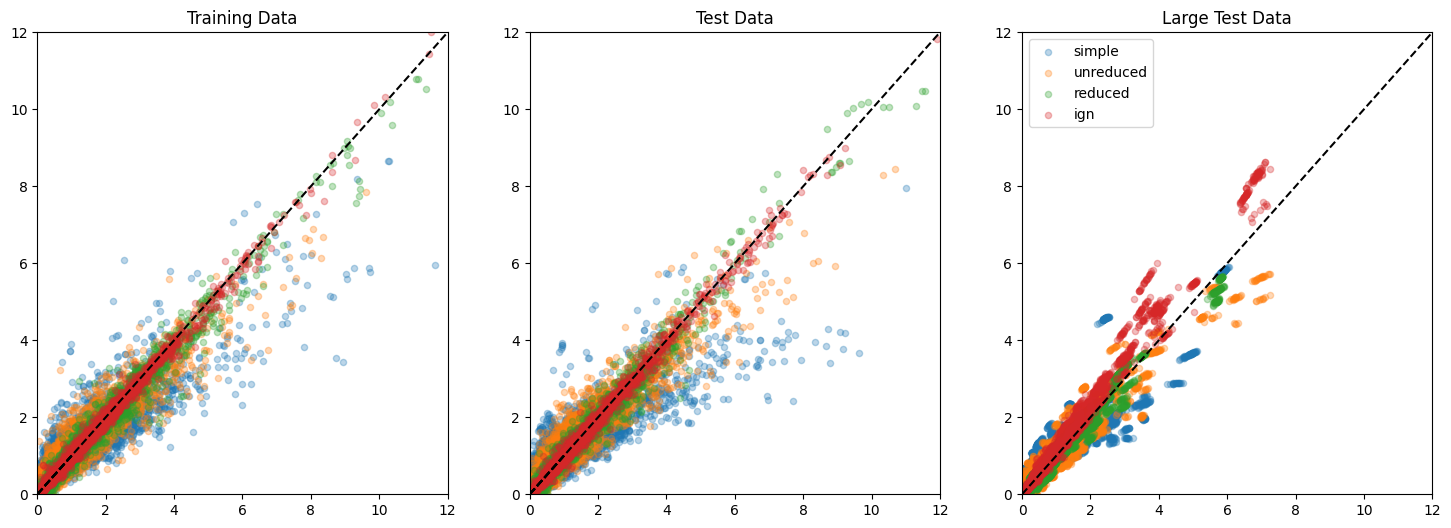

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for model in ["simple", "unreduced", "reduced", "ign"]:
    fname = f"outputs_full_SBM_Gaussian_triangle_{model}.pkl"
    large_fname = f"outputs_full_SBM_Gaussian_triangle_{model}_largetest.pkl"
    with open(os.path.join("log/size_generalization", fname), "rb") as f:
        out = pickle.load(f)
    with open(os.path.join("log/size_generalization", large_fname), "rb") as f:
        out_large = pickle.load(f)
    print(out.keys(), out_large.keys())

    # Training data
    train_subset = np.random.choice(len(out["train_outputs"]), 8000, replace=False)
    train_subset = train_subset.astype(int)
    axs[0].scatter(
        np.array(out["train_truths"])[train_subset],
        np.array(out["train_outputs"])[train_subset],
        label=model,
        alpha=0.3,
        s=20,
        marker="o",
    )
    axs[0].plot([0, 1], [0, 1], "--", color="black")
    axs[0].set_title("Training Data")

    # Test data
    test_subset = np.random.choice(len(out["test_outputs"]), 8000, replace=False)
    test_subset = test_subset.astype(int)
    axs[1].scatter(
        np.array(out["test_truths"])[test_subset],
        np.array(out["test_outputs"])[test_subset],
        label=model,
        alpha=0.3,
        s=20,
        marker="o",
    )
    axs[1].plot([0, 1], [0, 1], "--", color="black")
    axs[1].set_title("Test Data")

    # Large test data
    large_test_subset = np.random.choice(len(out_large["outputs"]), 8000, replace=False)
    large_test_subset = large_test_subset.astype(int)
    axs[2].scatter(
        np.array(out_large["truths"])[large_test_subset],
        np.array(out_large["outputs"])[large_test_subset],
        label=model,
        alpha=0.3,
        s=20,
        marker="o",
    )
    axs[2].set_title("Large Test Data")
for ax in axs:
    ax.plot([0, 12], [0, 12], "--", color="black")
    ax.set_xlim([0, 12])
    ax.set_ylim([0, 12])

plt.legend()
plt.show()

In [14]:
import pickle

dict = pickle.load(
    open("log/size_generalization/outputs_full_SBM_Gaussian_triangle_ign_largetest.pkl", "rb")
)
# train_outputs, test_outputs = dict["train_outputs"], dict["test_outputs"]
# train_truths, test_truths = dict["train_truths"], dict["test_truth"]
outputs, truth = dict["outputs"], dict["truth"]

In [17]:
len(outputs)

20

In [ ]:
state_dict["model.layers.0.A_l5.weight"]

In [ ]:
for key in state_dict.keys():
    if "A_l3" in key or "A_l5" in key:
        print(key)
        print(state_dict[key])

In [ ]:
for key in state_dict.keys():
    if "X1_l4" in key or "X1_l5" in key:
        print(key)
        print(state_dict[key])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def W(x, y):
    return 1 - np.exp(-2 * x * y)
    # return np.exp(-((x - y) ** 2)/0.1)


# Create a grid of x and y values
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Compute W(x, y) for each pair of x and y values
Z = W(X, Y)
print(Z.max(), Z.min())
# Plot the resulting matrix
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap="viridis")
plt.colorbar(label="W(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Graph of W(x, y) = exp(-(x-y)^2)")
plt.show()

In [ ]:
import torch

# Create a random tensor
tensor = torch.tensor([[3, 1, 4], [1, 5, 9], [2, 6, 5]])

# Sort the tensor along dimension 0 (rows)
sorted_tensor_dim0, indices_dim0 = torch.sort(tensor, dim=0)

# Sort the tensor along dimension 1 (columns)
sorted_tensor_dim1, indices_dim1 = torch.sort(tensor, dim=1)

In [ ]:
sorted_tensor_dim0